### Load and Format the Data

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

In [1]:
import moviepy.editor as mpe
import cv2
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
# video = mpe.VideoFileClip("movie/Video_003.avi")
video = cv2.VideoCapture("movie/Video_003.avi")

In [5]:
# video.duration
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps
print(duration)

113.57142857142857


### Helper Methods

In [10]:
def getFrame(sec):
    video.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = video.read()
    if hasFrames:
        return image
    else:
        return NULL
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def create_data_matrix_from_video(clip, fps=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(getFrame(i/float(fps))).astype(int), scale).flatten() for i in range(fps * int(duration))]).T

### Format the Data

An image from 1 moment in time is 120 pixels by 160 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $120 \times 160$, we have a $1 \times 19,200$ column 

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every hundredth of a second for 100 seconds (so 10,000 different images, each from a different point in time), we'd have a $10,000 \times 19,200$ matrix, representing the video! 

In [11]:
scale = 0.50   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))
fps = 60      # frames per second

In [12]:
M = create_data_matrix_from_video(video, fps, scale)
# M = np.load("movie/med_res_surveillance_matrix_60fps.npy")

In [13]:
print(dims, M.shape)

(120, 160) (19200, 6780)


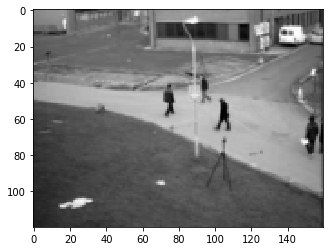

In [14]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [15]:
np.save("movie/med_res_surveillance_matrix_60fps_opencv.npy", M)

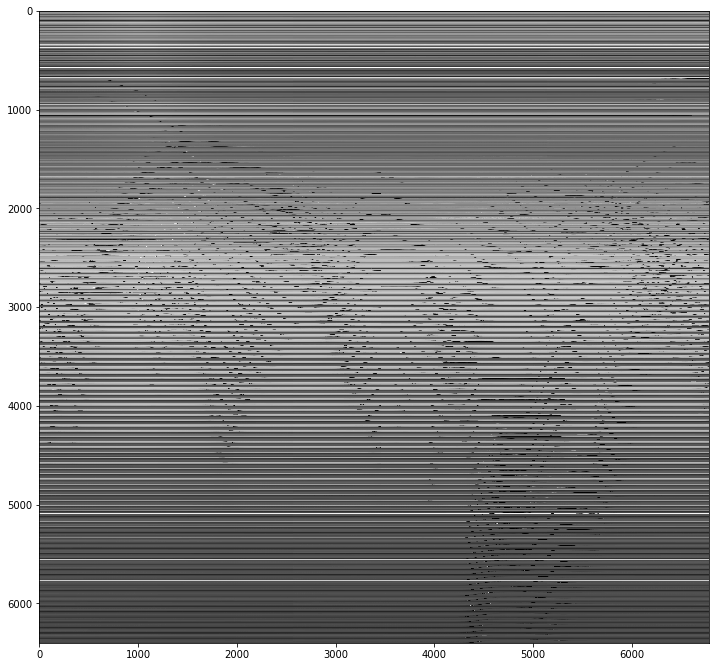

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(M[::3,:], cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

## Singular Value Decomposition

### Intro to SVD

“a convenient way for breaking a matrix into simpler, meaningful pieces we care about” – [David Austin](http://www.ams.org/samplings/feature-column/fcarc-svd)

“the most important linear algebra concept I don’t remember learning” - [Daniel Lemire](http://lemire.me/blog/2010/07/05/the-five-most-important-algorithms/)

**Applications of SVD**:
- Principal Component Analysis
- Data compression
- Pseudo-inverse
- Collaborative Filtering
- Topic Modeling
- Background Removal
- Removing Corrupted Data

In [17]:
U, s, V = np.linalg.svd(M, full_matrices=False)

This is really slow, so you may want to save your result to use in the future.

In [18]:
np.save("movie/U_cv2.npy", U)
np.save("movie/s_cv2.npy", s)
np.save("movie/V_cv2.npy", V)

In the future, you can just load what you've saved:

In [19]:
U = np.load("movie/U_cv2.npy")
s = np.load("movie/s_cv2.npy")
V = np.load("movie/V_cv2.npy")

What do $U$, $S$, and $V$ look like?

In [20]:
U.shape, s.shape, V.shape

((19200, 6780), (6780,), (6780, 6780))

#### Exercise

Check that they are a decomposition of M

In [ ]:
#Exercise: 


They are! :-)

In [ ]:
np.allclose(M, reconstructed_matrix)

In [ ]:
np.set_printoptions(suppress=True, precision=0)

#### Properties of S

s is the diagonal of a *diagonal matrix*

In [ ]:
np.diag(s[:6])

Do you see anything about the order for $s$?

In [ ]:
s[0:2000:50]

In [ ]:
len(s)

In [ ]:
s[700]

In [ ]:
np.set_printoptions(suppress=True, precision=4)

$U$ is a giant matrix, so let's just look at a tiny bit of it:

In [ ]:
U[:5,:5]

### Finding the background

In [ ]:
U.shape, s.shape, V.shape

In [21]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

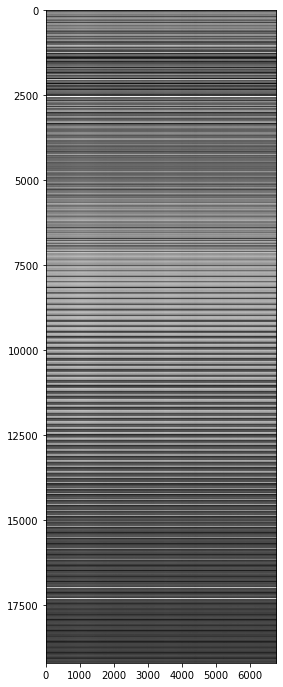

In [22]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

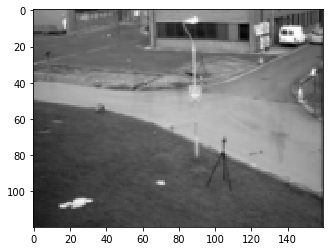

In [23]:
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray');

How do we get the people from here?

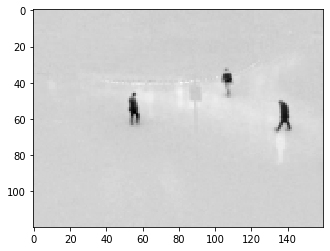

In [24]:
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray');

High-resolution version

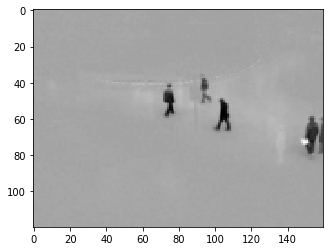

In [25]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

#### Make Video

In [26]:
from moviepy.video.io.bindings import mplfig_to_npimage

In [27]:
def make_video(matrix, dims, filename):
    mat_reshaped = np.reshape(matrix, (dims[0], dims[1], -1))
    
    fig, ax = plt.subplots()
    def make_frame(t):
        ax.clear()
        ax.imshow(mat_reshaped[...,int(t*fps)])
        return mplfig_to_npimage(fig)
    
    animation = mpe.VideoClip(make_frame, duration=int(10))
    animation.write_videofile('videos/' + filename + '.mp4', fps=fps)

t:   0%|          | 0/600 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos/figures2.mp4.
Moviepy - Writing video videos/figures2.mp4




t:  42%|████▏     | 249/600 [00:18<00:26, 13.03it/s, now=None]


t:  82%|████████▏ | 493/600 [00:38<00:07, 13.74it/s, now=None]


t:   0%|          | 2/600 [01:29<03:19,  3.00it/s, now=None]  

Moviepy - Done !
Moviepy - video ready videos/figures2.mp4


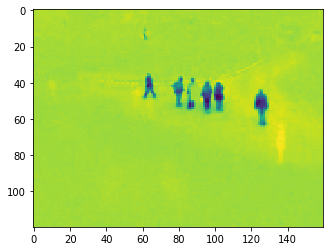

In [29]:
make_video(M - low_rank, dims, "figures2")

The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$